# BCPC quick demonstration
Runs the full pipeline on `input/sample_scenario.csv` and previews the output GeoJSON.

In [2]:
pip install folium


  Using cached folium-0.20.0-py2.py3-none-any.whl.metadata (4.2 kB)
  Using cached branca-0.8.1-py3-none-any.whl.metadata (1.5 kB)
Using cached folium-0.20.0-py2.py3-none-any.whl (113 kB)
Using cached branca-0.8.1-py3-none-any.whl (26 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [folium]
Note: you may need to restart the kernel to use updated packages.


In [3]:
# --------------------------------------------------
# 0 ▸ Imports & helper
# --------------------------------------------------
import glob
import json
from pathlib import Path

import geopandas as gpd
import pandas as pd
import folium                    # comes with the repo’s Poetry env

OUTPUT_DIR = Path("../output")   # adjust if your notebook lives elsewhere

def _load_tracks(output_dir: Path) -> gpd.GeoDataFrame:
    """Read every *_tracks.geojson file into a single GeoDataFrame (WGS-84)."""
    files = sorted(output_dir.glob("*_tracks.geojson"))
    if not files:
        raise FileNotFoundError("No *_tracks.geojson found – run the pipeline first")

    gdfs = [
        gpd.read_file(f).assign(city=f.stem.split("_")[1])  # e.g. LB-BEY_tracks → BEY
        for f in files
    ]
    return pd.concat(gdfs, ignore_index=True).pipe(gpd.GeoDataFrame, crs="EPSG:4326")


In [4]:
# --------------------------------------------------
# 1 ▸ Load + quick look
# --------------------------------------------------
tracks = _load_tracks(OUTPUT_DIR)
tracks.head()


,length_km,geometry,city
0,0.000059,"LINESTRING (35.5807 33.79275, 35.58092 33.7961...",tracks
1,0.000106,"LINESTRING (36.15435 34.01837, 36.15444 34.018...",tracks
2,0.000039,"LINESTRING (35.64256 34.1223, 35.64395 34.1223...",tracks
3,0.000089,"LINESTRING (35.47033 33.89219, 35.47056 33.893...",tracks
4,0.000061,"LINESTRING (35.35964 33.53699, 35.39311 33.58855)",tracks


In [6]:
# --------------------------------------------------
# 2 ▸ Interactive map with Folium  (patched)
# --------------------------------------------------
centroid = tracks.unary_union.centroid
c_lat, c_lon = centroid.y, centroid.x          # <-- FIXED LINE

m = folium.Map(location=[c_lat, c_lon], zoom_start=8, tiles="CartoDB positron")

for _, row in tracks.iterrows():
    hue = hash(row["city"]) % 360
    style = {"color": f"hsl({hue},70%,45%)", "weight": 4}
    folium.GeoJson(
        row["geometry"],
        name=row["city"],
        style_function=lambda *_: style
    ).add_to(m)

folium.LayerControl().add_to(m)
m



/var/folders/_k/9xjyljgs0f763brjmdsjbd080000gn/T/ipykernel_41517/3146604193.py:4: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = tracks.unary_union.centroid


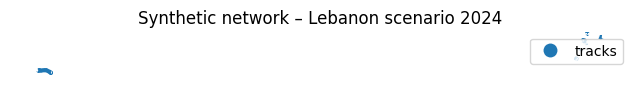

In [7]:
# --------------------------------------------------
# 3 ▸ Static overview (optional) – GeoPandas quick plot
# --------------------------------------------------
ax = tracks.plot(figsize=(8, 8), linewidth=3, column="city", legend=True)
ax.set_title("Synthetic network – Lebanon scenario 2024")

ax.set_axis_off()
